In [1]:
# import libraries

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandana
import pandas as pd
from shapely.geometry import Point

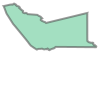

In [2]:
# Set the area of analysis: Alameda County

alameda_gdf = ox.geocode_to_gdf('Alameda County, CA')
alameda_polygon = alameda_gdf["geometry"].iloc[0]
alameda_polygon

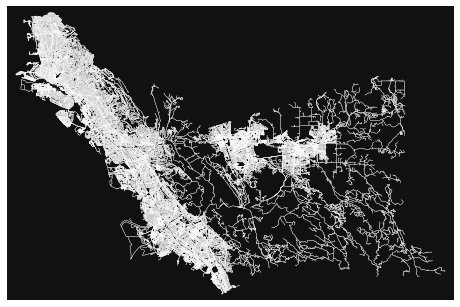

In [3]:
# Model the walking network for the area

G_walk = ox.graph_from_polygon(alameda_polygon, network_type='walk')
fig, ax = ox.plot_graph(G_walk, node_size=0, edge_color='w', edge_linewidth=0.3)

In [4]:
# set a uniform walking speed of 4.5 kph on every edge

for u, v, data in G_walk.edges(data=True):
    data['speed_kph'] = 4.5
G_walk = ox.add_edge_travel_times(G_walk)

In [5]:
# extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)

nodes = ox.graph_to_gdfs(G_walk, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(G_walk, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
# # Get the location data for city parks within the study region

# parks = ox.geometries_from_bbox(north=nodes['y'].max(),
#                                     south=nodes['y'].min(),
#                                     east=nodes['x'].min(),
#                                     west=nodes['x'].max(),
#                                     tags={'leisure': 'park'})
# print(parks.shape)
# parks.head()

In [7]:
# parks.plot();

In [8]:
# Read in the data for East Bay Regional Parks

parks_df = gpd.read_file("data/East_Bay_Regional_Parks.geojson")
parks_df.head()

,name,shape_area,objectid,status,shape_len,geometry
0,ALAMEDA CREEK TRAIL,345039.183567,1,PARKLAND,3934.39887667,"MULTIPOLYGON (((-122.07007 37.56657, -122.0690..."
1,ANTHONY CHABOT,82549.3860061,2,LANDBANK,1821.59233197,"MULTIPOLYGON (((-122.17007 37.80474, -122.1701..."
2,ANTHONY CHABOT,135269896.913,3,PARKLAND,147613.488464,"MULTIPOLYGON (((-122.16205 37.80332, -122.1618..."
3,DUBLIN HILLS,5095057.12292,41,PARKLAND,11256.7353154,"MULTIPOLYGON (((-121.96937 37.70978, -121.9689..."
4,EAST BAY SHORELINE STATE PARK,80707996.8944,42,LANDBANK,128184.48146,"MULTIPOLYGON (((-122.30520 37.86559, -122.3051..."


<AxesSubplot:>

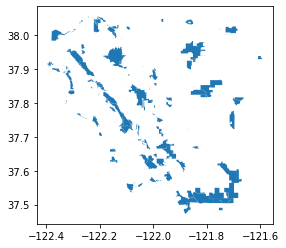

In [9]:
parks_df.plot()

In [10]:
# construct the pandana network model

network = pandana.Network(node_x=nodes['x'],
                          node_y=nodes['y'], 
                          edge_from=edges['u'],
                          edge_to=edges['v'],
                          edge_weights=edges[['travel_time']])

Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 132189
Setting CH edge vector of size 366610
Range graph removed 376428 edges of 733220
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [11]:
# extract (approximate, unprojected) centroids from the amenities' geometries

centroids = parks_df.centroid

/var/folders/0p/d58gfby91zv_mj3nb5kz5_9c0000gn/T/ipykernel_11616/2457168872.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = parks_df.centroid


In [12]:
# specify max travel distance for the analysis
# then set the park locations on the network

maxdist = 15 * 60  # 15 minutes converted to seconds
network.set_pois(category='parks',
                 maxdist=maxdist,
                 maxitems=3,
                 x_col=centroids.x, 
                 y_col=centroids.y)

In [13]:
# calculate travel time to nearest park from each node in network
distances = network.nearest_pois(distance=maxdist,
                                 category='parks',
                                 num_pois=3)
distances.astype(int).head()

,1,2,3
osmid,,,
30366200,900,900,900
32972114,900,900,900
32972116,900,900,900
32972118,900,900,900
32972120,900,900,900


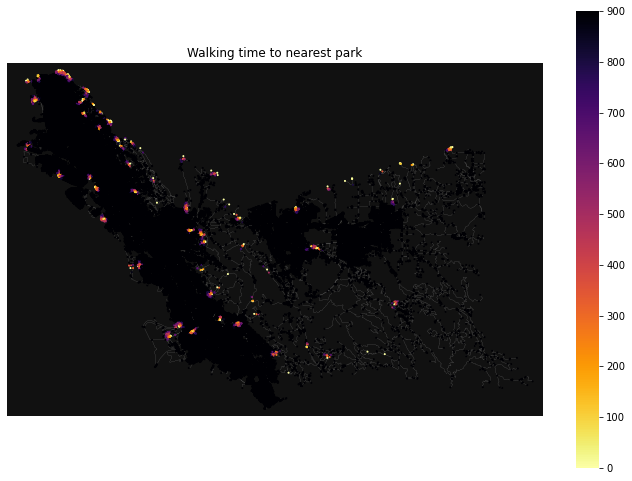

In [14]:
# plot distance to nearest park

fig, ax = ox.plot_graph(G_walk, node_size=0, edge_linewidth=0.1,
                        edge_color='gray', show=False, close=False,
                        figsize=(12,12)
                       )

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'], 
                c=distances[1],
                s=1,
                cmap='inferno_r')

ax.set_title(f'Walking time to nearest park')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [15]:
# select the nodes in the network where parks are located
node_ids = network.get_node_ids(centroids.x, centroids.y)

# set a variable related to the park nodes in the network
network.set(node_ids, name='parks')

# calculate the variable for every origin node in the network
# as the number of park nodes within a maximum distance of it
access = network.aggregate(distance=maxdist,
                           type='count',
                           decay='linear',
                           name='parks'
                          )

# Cap the variable at 5 parks
access= access.clip(upper=5)

access.describe()

count    132189.000000
mean          0.034080
std           0.241406
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           5.000000
dtype: float64

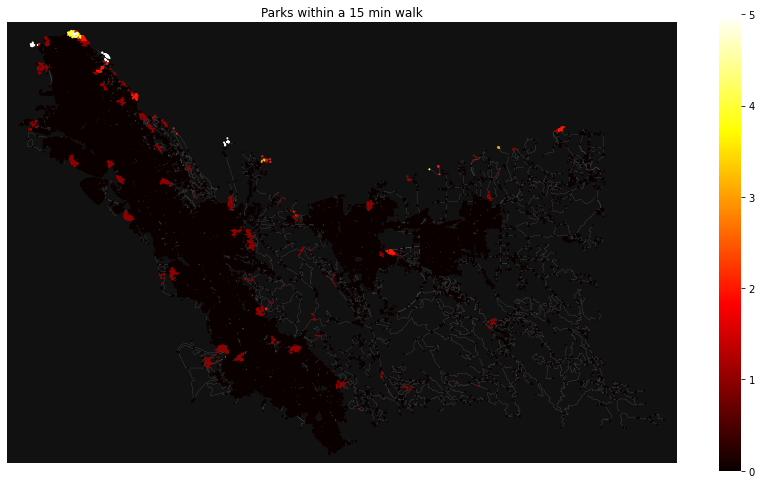

In [18]:
# plot the number of parks within 15 min walking distance
# of each node in the network

fig, ax = ox.plot_graph(G_walk, 
                        node_size=0, 
                        edge_linewidth=0.1,
                        edge_color='gray',
                        show=False,
                        close=False,
                        figsize=(15,12)
                       )

sc = ax.scatter(x=nodes['x'],
                y=nodes['y'],
                c=access,
                s=1,
                cmap='hot')

ax.set_title('Parks within a 15 min walk')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [ ]:
# We now have a Pandas Series for the park access variable 
# (i.e. number of parks within walking distance) 
# indexed by node ids from the Pandana network.

access.head()

## Conclusion

Very few neighborhoods are within a 15 minute walking distance of a regional park.